## Detecting changes in protein localization in high-throughput microscopy

Cells often respond to their environment by changing the localization of proteins,
so identifying proteins that move to a different compartment in a cell in response
to a perturbation can help characterize a cell's regulatory response. In this
notebook, we automate detecting these changes from high-content
image screens, which collect an image of each protein in cells under a perturbation
relative to an untreated wild-type control, using self-supervised deep learning and
statistical correction techniques.

First, let's look at some microscopy images from the CYCLoPS database:

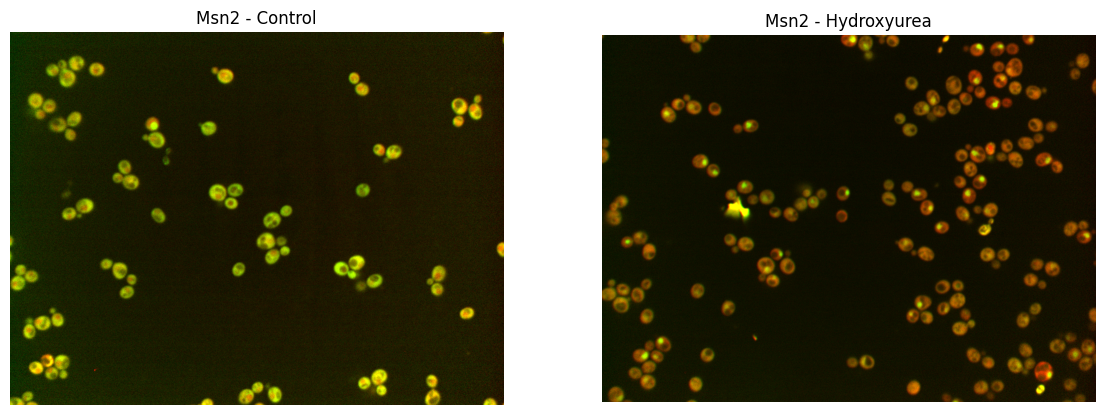

In [3]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity

# Open WT control images
howt_g = np.array(Image.open('./data/cyclops/CTRL/MSN2_ch1_1.tif'))
howt_r = np.array(Image.open('./data/cyclops/CTRL/MSN2_ch2_1.tif'))

# Rescale for visualization
howt_g = rescale_intensity(howt_g, out_range=(0, 1), in_range=(np.percentile(howt_g, 0.1), np.percentile(howt_g, 99.9)))
howt_r = rescale_intensity(howt_r, out_range=(0, 1), in_range=(np.percentile(howt_r, 0.1), np.percentile(howt_r, 99.9)))
howt_img = np.stack((howt_r, howt_g, np.zeros_like(howt_r)), axis=-1)

# Open hydroxyurea images
hu_g = np.array(Image.open('./data/cyclops/HU02/MSN2_ch1_1.tif'))
hu_r = np.array(Image.open('./data/cyclops/HU02/MSN2_ch2_1.tif'))

# Rescale for visualization
hu_g = rescale_intensity(hu_g, out_range=(0, 1), in_range=(np.percentile(hu_g, 0.1), np.percentile(hu_g, 99.9)))
hu_r = rescale_intensity(hu_r, out_range=(0, 1), in_range=(np.percentile(hu_r, 0.1), np.percentile(hu_r, 99.9)))
hu_img = np.stack((hu_r, hu_g, np.zeros_like(hu_r)), axis=-1)

# Plot
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(howt_img)
ax1.set_title("Msn2 - Control")
ax1.axis("off")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(hu_img)
ax2.set_title("Msn2 - Hydroxyurea")
ax2.axis("off")
plt.show()

These images show the yeast transcription factor Msn2, expressed in control
cells compared to cells treated with hydroxyurea. The protein (tagged with GFP)
is shown in green, and since the CYCLoPS dataset uses a cytoplasmic RFP to
visualize the cell, the cytoplasm of the cell is shown in red. Most cells in
the control express Msn2 in the cytoplasm, but under hydroxyurea treatment,
Msn2 is now localized to the nucleus in many more cells. These are the types
of localization changes that we would like to detect with our computational pipeline.

## Step 1: Segmenting images into single cell crops

The first step in our analysis will be segmenting these images into single cell crops. We'll use YeastSpotter to do this
since it's a general purpose segmentation method that will work on many kinds of modalities. We've integrated
YeastSpotter into this repository, and it can be called as below:


In [5]:
import warnings
warnings.filterwarnings("ignore")
import segmentation.yeastspotter.utils as ys_utils

ys_utils.segment_directory(input_dir = './data/cyclops/CTRL/',                   # Input directory
                           output_dir = './data/cyclops_segmented/CTRL/',        # Output directory to save segmentation
                           rescale = True,                                       # Rescale images to speed up segmentation
                           scale_factor = 2.0,                                   # Factor to rescale images (divide size by 2.0)
                           verbose = True,                                       # Print out process
                           contains_str = '_ch2_')                               # Only segment images containing "ch2" (i.e. RFP channel)


Preprocessing images...
Preprocessing  MSN2_ch2_1.tif

Running your images through the neural network...
Loading weights from  C:\Users\lualex\PycharmProjects\change_detection_book_chapter\segmentation\yeastspotter\mrcnn\../weights/deepretina_final.h5
Start detect 0    MSN2_ch2_1
Completed in 10.963568449020386

Saving the masks...
Converting MSN2_ch2_1 to mask...
Completed in 0.501502275466919
Completed segmentation!


YeastSpotter will produce segmentation masks where each cell is assigned its own unique integer:

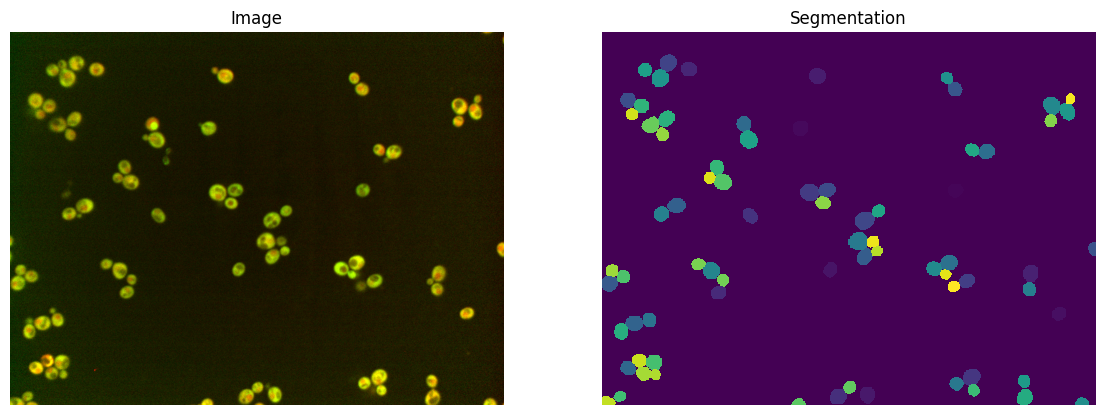

In [6]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Open and rescale microscopy image
howt_g = np.array(Image.open('./data/cyclops/CTRL/MSN2_ch1_1.tif'))
howt_r = np.array(Image.open('./data/cyclops/CTRL/MSN2_ch2_1.tif'))
howt_g = rescale_intensity(howt_g, out_range=(0, 1), in_range=(np.percentile(howt_g, 0.1), np.percentile(howt_g, 99.9)))
howt_r = rescale_intensity(howt_r, out_range=(0, 1), in_range=(np.percentile(howt_r, 0.1), np.percentile(howt_r, 99.9)))
howt_img = np.stack((howt_r, howt_g, np.zeros_like(howt_r)), axis=-1)

# Open segmentation mask image
howt_seg = np.array(Image.open('./data/cyclops_segmented/CTRL/masks/MSN2_ch2_1.tif'))

# Visualize
fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(howt_img)
ax1.set_title("Image")
ax1.axis("off")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(howt_seg, interpolation='nearest')
ax2.set_title("Segmentation")
ax2.axis("off")
plt.show()

We will use these segmentation masks to crop the full microscopy image into multiple 64x64 single cell crops. These
crops will be fed into a deep learning model that will learn and extract single cell feature representations. Since
the model we use is robust to the presence of e.g. multiple cells in a crop, we only need to use the center of each
segmented cell to determine crops (and not the exact boundaries of the segmentation).

In [8]:
import segmentation.yeastspotter.utils as ys_utils

ys_utils.batch_crop_single_cells(
    image_dir = './data/cyclops/CTRL/',                         # Image directory
    mask_dir = './data/cyclops_segmented/CTRL/masks/',          # Mask directory
    output_dir = './data/cyclops_segmented/CTRL/single_cells/', # Output directory for single cells
    cropsize=64,                                                # Pixel size of square to crop from images
    resize=64,                                                  # Pixel size of square to resize cropped images into
    additional_img_strs = [("_ch2_", "_ch1_")])                 # By default, the script will only segment images in the image
                                                                # directory with an identical name to the mask images
                                                                # To also segment additional images, provide a list of tuples
                                                                # of string replacements that will identify these images.

Working on MSN2_ch2_1.tif
Successfully cropped all images.


The above code block should result in a directory of single cell crops (with channels saved as individual images).
The code block below shows some random samples:

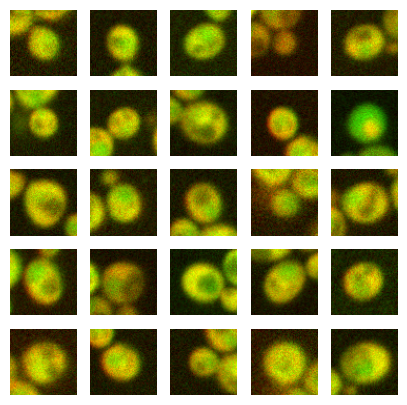

In [9]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import glob
from skimage.exposure import rescale_intensity

single_cell_dir = './data/cyclops_segmented/CTRL/single_cells/MSN2/'
single_cells = glob.glob(single_cell_dir + "*_ch2_*.tif")

fig = plt.figure(figsize=(5, 5))
fig_counter = 1

# Pick 25 random cells and show them in a grid
for cell_name in np.random.choice(single_cells, 25, replace=False):
    gfp = np.array(Image.open(cell_name))
    rfp = np.array(Image.open(cell_name.replace("_ch2_", "_ch1_")))

    # Rescale intensity of raw tif files so they display nicely as RGB image
    gfp = rescale_intensity(gfp, out_range=(0, 1))
    rfp = rescale_intensity(rfp, out_range=(0, 1))
    img = np.stack((rfp, gfp, np.zeros_like(gfp)), axis=-1)

    ax = fig.add_subplot(5, 5, fig_counter)
    ax.imshow(img)
    ax.axis("off")

    fig_counter += 1

plt.show()

The above segmentation steps can be batched over a whole screen of images. This step is too time-consuming for our
tutorial, so if you would like to follow along with the next step, which involves training a self-supervised deep
learning model to learn feature representations of these images, you can download a complete screen of segmented
single cells from (ZENODO LINK). Otherwise, skip to Step 3, which involves extracting features from a trained neural
network (we provide weights in this step so you don't need to complete Step 2 for yourself.)

## Step 2: Train a self-supervised deep learning model on single cell crops

We'd like to compare these images to determine if the population of single cells in the hydroxyurea images differs in
protein localization compared to the control. To do this, we must first convert the images into feature representations,
which in this case are vectors of numerical measurements describing how proteins distribute in cells. Classically,
feature representations are hand-crafted (for example, [measuring the average distance of proteins to the cell
edge](https://pubmed.ncbi.nlm.nih.gov/23785265/), or [the correlation of proteins with the microtubles of a
cell](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004614)). More recently, deep learning
methods are used to design features. This strategy has the advantage of reducing labor (because features no longer have
to be designed bespoke with domain knowledge), and improving performance (because features optimized by a neural network
can be more sensitive to biology than those hand-crafted by an expert).

In this section, we will use self-supervised learning to train a neural network to learn features describing protein
localization in single cells. Self-supervised learning trains neural networks on "proxy tasks". These proxy tasks do
not need to produce directly useful outputs, but should be fully autonomous (so no expert labeling of data is required),
and teach the model transferable features useful to the actual task of interest. We previously designed a
self-supervised method called [paired cell inpainting](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007348).
This method trains a neural network on a "coloring book by example" problem: given an image of what protein
expression looks like in one cell in an image (a "source cell"), the model has to predict what protein expression will
look like in a second cell from the same image (the "target cell").

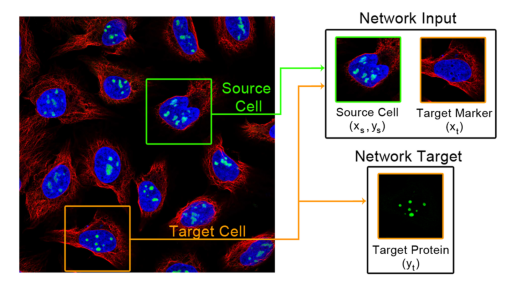

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

plt.imshow(np.array(Image.open("images/pci.png")))
plt.axis("off")
plt.show()

We will train a paired cell inpainting model, using the kinds of single cell crops shown in the step above. We've made
over 1.1 million single cell crops available at (ZENODO LINK). These crops are extracted from images of over 4,000
proteins for an untreated wild-type control cells. We'll train a paired cell inpainting model on this data.
Because this model will take about a week to train on a single GPU, we won't actually run it in this notebook, but the
code snippet to replicate this model is below:


In [ ]:
from paired_cell_inpainting.train import train

train (
    data_paths = './data/HOwt/HOwt_single_cell/',                # Directory of single cells to train on
    batch_size = 64,                                             # Batch size
    learning_rate = 1e-4,                                        # Learning rate
    epochs = 30,                                                 # Epochs
    checkpoint_path = './paired_cell_inpainting/weights/',       # Where to save weights
    save_freq=10,                   # Save checkpoint every 10 epochs
    im_h=64,                        # Height of single cell crops
    im_w=64,                        # Width of single cell crops
    min_cells=30)                   # Only train on images with at least 30 single cells

The weights of this trained model will be saved in the location specified under "checkpoint_path". You can grab a copy
of the weights we've trained from (ZENODO LINK) and use this for the next step, which will extract features using the
trained paired cell inpainting model.

## Step 3: Extract protein features using trained deep learning model

Having trained a paired cell inpating model, our next step is to use this model to extract features measuring protein
localization in single yeast cells. To do this, we'll need to prune the model architecture after loading the weights
for this model. The paired cell inpainting model is trained to output an image of predicted protein localization, but
this image isn't directly useful for our goal of representing cells as features. Instead, we want the information that
the model has to extract from the input images in order to solve the problem of generating this predicted output - aka
our feature representation. We'll need to prune away the decoder layers that generate the image, and instead extract
these features from an intermediate layer of an encoder in the paired cell inpainting model. The below code block
shows how to do this - usually, the 3rd or 4th layer of the source cell encoder works best. We'll extract these
features for a smaller evaluation dataset of about 28k annotated single cells to demonstrate (these images are
available as a zip file at (LINK)):

In [1]:
from paired_cell_inpainting.pair_model import Pair_Model
from paired_cell_inpainting.extract_features import extract_features
import tensorflow as tf

# Initialize and load model weights
model = Pair_Model().create_model(x_shape=(64, 64, 2), y_shape=(64, 64, 1))
model.load_weights("./paired_cell_inpainting/weights/model_weights.h5")

# Prune decoder, target encoder, and final layer of the source cell encoder
pruned_model = tf.keras.Model(inputs=model.get_layer("x_in").input,
                              outputs=model.get_layer("conv4_1").output)

# Extract features from demonstration single cells
extract_features(target_directory = './data/labeled_single_cells/',     # Input directory (subdirectories of images)
                 model = pruned_model,                                  # Pruned model for feature extraction
                 out_path = './data/labeled_single_cell_features.tsv',  # Output for features
                 single_cell=True)                                      # Extract single cell features

update your tensorflow
Building model...
Extracting features from images...
Extracted features for  0 cells
Extracted features for  1000 cells
Extracted features for  2000 cells
Extracted features for  3000 cells
Extracted features for  4000 cells
Extracted features for  5000 cells
Extracted features for  6000 cells
Extracted features for  7000 cells
Extracted features for  8000 cells
Extracted features for  9000 cells
Extracted features for  10000 cells
Extracted features for  11000 cells
Extracted features for  12000 cells
Extracted features for  13000 cells
Extracted features for  14000 cells
Extracted features for  15000 cells
Extracted features for  16000 cells
Extracted features for  17000 cells
Extracted features for  18000 cells
Extracted features for  19000 cells
Extracted features for  20000 cells
Extracted features for  21000 cells
Extracted features for  22000 cells
Extracted features for  23000 cells
Extracted features for  24000 cells
Extracted features for  25000 cells
E

Let's visualize these features as a UMAP:

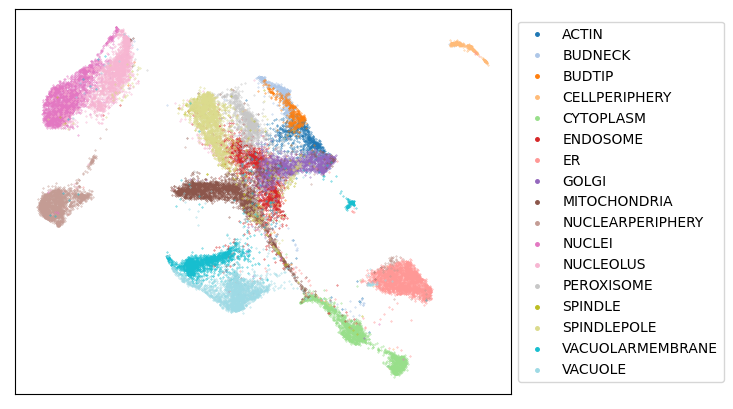

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
import csv
import numpy as np

fn = './data/labeled_single_cell_features.tsv'
data = np.array([x for x in csv.reader(open(fn), delimiter="\t")])[1:]
labels = np.array([x.split("_")[0] for x in data[:, 0]])
features = data[:, 1:].astype(float)
features = StandardScaler().fit_transform(features)

projection = umap.UMAP(metric="euclidean", n_neighbors=30).fit_transform(features)
classes = np.unique(labels)
cmap = plt.get_cmap('tab20')
c_ids = cmap(np.linspace(0, 1.0, len(classes)))

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()
i = 0
for c in classes:
    ix = np.where(labels == c)
    ax.scatter(projection[ix, 0], projection[ix, 1], c=np.array([c_ids[i]]),
               marker='o', label=c, s=0.1)
    i += 1
ax.set_xticks([])
ax.set_yticks([])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=8)
plt.show()

As you can see, single cells with different protein localizations are well-separated in the feature space learned
by our paired cell inpainting model.

Next, we will apply this model to extract features from all single cells in both the control and hydroxyurea screens.
Since we'd like to identify changes at the level of *proteins*, we need to aggregate these single cell representations
into a feature vector for each protein in each screen. To do this, we will simply average together the features for
all single cells with the same protein tagged in each screen.

Extracting features for screens this large is a time-consuming operation, so we will not reproduce it in this notebook,
but the code to replicate this is below:


In [ ]:
from paired_cell_inpainting.pair_model import Pair_Model
from paired_cell_inpainting.extract_features import extract_features
import tensorflow as tf

# Initialize and load model weights
model = Pair_Model().create_model(x_shape=(64, 64, 2), y_shape=(64, 64, 1))
model.load_weights("./paired_cell_inpainting/weights/model_weights.h5")

# Prune decoder, target encoder, and final layer of the source cell encoder
pruned_model = tf.keras.Model(inputs=model.get_layer("x_in").input,
                              outputs=model.get_layer("conv4_1").output)

# Extract features from demonstration single cells
extract_features(target_directory = './data/cyclops_segmented/HOwt/',    # Input directory (subdirectories of images)
                 model = pruned_model,                                   # Pruned model for feature extraction
                 out_path = './data/HOwt_features.tsv',                  # Output for features
                 single_cell=False,                                      # Extract aggregated protein features
                 min_cells=30)                                           # Only consider images with >= 30 cells

extract_features(target_directory = './data/cyclops_segmented/HU02/',     # Input directory (subdirectories of images)
                 model = pruned_model,                                    # Pruned model for feature extraction
                 out_path = './data/HU02_features.tsv',                   # Output for features
                 single_cell=False,                                       # Extract aggregated protein features
                 min_cells=30)                                            # Only consider images with >= 30 cells

## Step 4: Perform change detection on extracted features

We now have feature representations for each protein in each screen. By comparing these representations, we can
detect if there are changes in protein localization in the control versus hydroyxurea-treated cells!

However, directly comparing the representations is noisy. This is because cells often exhibit systematic changes in
morphology (and other factors) in response to environmental perturbation. For example, some drugs can cause vacuoles
in yeast to fragment from a large single vacuole, to multiple smaller vacuoles. If we were to compare representations
directly, we would likely find that every vacuole-localized protein has changes under these drugs. Technically, this
is a real change altering how the protein distributes in the cell. However, it's not an interesting change
for our purposes:  we'd like to find proteins that move from the vacuole to a different cellular compartment, not
proteins that remain in the vacuole, but look different only due to systematic differences in vacuole morphology and
distribution.

To correct for these systematic effects, we can employ a simple nearest-neighbor strategy: for each protein, we'll
compare its change to the 50 most similarly localized neighbors in the control. If the change differs drastically
from its neighbors, we'll consider that protein to actually be changing in localization. Otherwise, if the change
is similar to that of its neighbors, even if the change is very large in feature space, we'll consider this change
to be a systematic one for most proteins localized to that compartment and dampen it. To implement this concept, we
calculate a z-score for each feature, of the protein compared to an expectation using the mean and standard deviation
of its 50 nearest neighbors.

In [3]:
from change_detection.change_detection import knn_change_detection

knn_change_detection(reference = './data/HOwt_features.tsv',    # Features for control
                     condition = './data/HU02_features.tsv',    # Features for perturbation
                     output = './data/HU02_changes.tsv',        # Output to save to
                     k=50,              # N neighbors to use in change detection
                     verbose=True)

Filtering to intersection of proteins in both datasets...
Calculating z-scores...
Calculated expectations for 200 out of 3616 proteins.
Calculated expectations for 400 out of 3616 proteins.
Calculated expectations for 600 out of 3616 proteins.
Calculated expectations for 800 out of 3616 proteins.
Calculated expectations for 1000 out of 3616 proteins.
Calculated expectations for 1200 out of 3616 proteins.
Calculated expectations for 1400 out of 3616 proteins.
Calculated expectations for 1600 out of 3616 proteins.
Calculated expectations for 1800 out of 3616 proteins.
Calculated expectations for 2000 out of 3616 proteins.
Calculated expectations for 2200 out of 3616 proteins.
Calculated expectations for 2400 out of 3616 proteins.
Calculated expectations for 2600 out of 3616 proteins.
Calculated expectations for 2800 out of 3616 proteins.
Calculated expectations for 3000 out of 3616 proteins.
Calculated expectations for 3200 out of 3616 proteins.
Calculated expectations for 3400 out of 36

## Step 5: Visualizing change detection output

Analyzing the change detection file can be as simple as ranking the change detection vectors by magnitude - this
produces a ranked list of putative protein localization changes. However, we've found it useful to visualize some of
these changes.

First, let's start off by visualizing the global effects in the dataset. These are **not** the real detected changes,
but just visualizing systematic technical and biological changes in proteins between the control and condition.

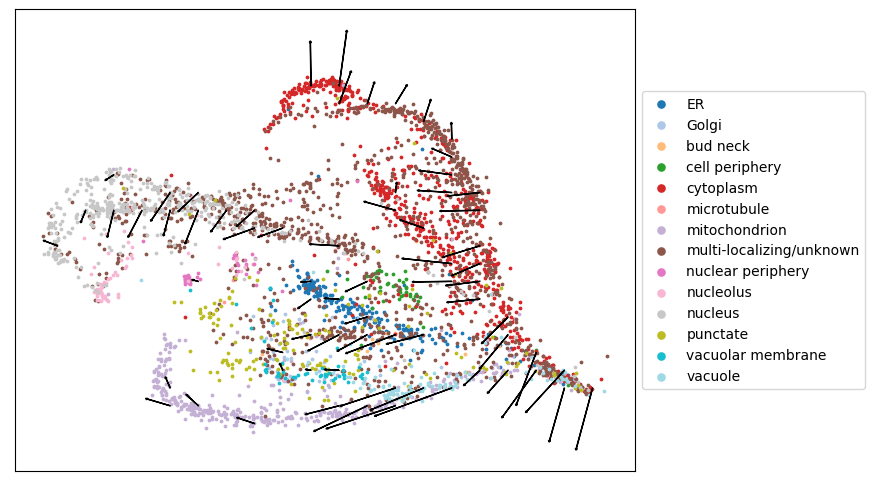

In [7]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from visualization.change_vis import visualize_global_effects, filter_matrices, get_localization_labels, \
    open_matrix, clean_localization_labels

# Locations of features, change vectors, and localization label files
control = "./data/HOwt_features.tsv"
condition = "./data/HU02_features.tsv"
change = "./data/HU02_changes.tsv"
localizations = './data/yeast_localizations.tsv'

# Open files
protein_names, sorted_control, sorted_condition, _ = filter_matrices(control, condition)
_, _, change = open_matrix(change)
localization_labels = get_localization_labels(protein_names, localizations)

# Clean up localization labels for visualization
localization_labels = clean_localization_labels(localization_labels)

# Visualize global effects
visualize_global_effects(sorted_control, sorted_condition, protein_names, localization_labels)

In the above visualization, each point represents a protein in the condition, labeled by a previous manual evaluation
of the yeast GFP collection by Huh *et al*. 2002. The arrows represent the average condition-induced change in the
representation space for proteins in the vicinity of the arrow. According to this visualization, most proteins show
concerted, systematic changes in the representation space between the control and hydroxyurea treatment. Since most
proteins in the proteome are not expected to relocalize under any single perturbation, it's unlikely that all of these
changes are "real" localization changes.

Next, let's visualize the top 10 changes ranked by the change detection algorithm, which controls for these systematic
shifts:

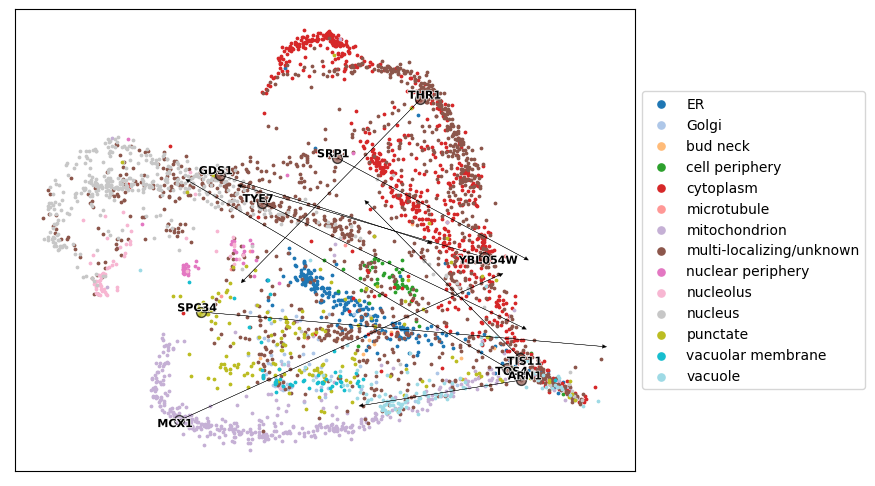

In [2]:
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from visualization.change_vis import visualize_changes, filter_matrices, get_localization_labels, \
    open_matrix, clean_localization_labels

# Locations of features, change vectors, and localization label files
control = "./data/HOwt_features.tsv"
condition = "./data/HU02_features.tsv"
change = "./data/HU02_changes.tsv"
localizations = './data/yeast_localizations.tsv'

# Open files
protein_names, sorted_control, sorted_condition, _ = filter_matrices(control, condition)
_, _, change = open_matrix(change)
localization_labels = get_localization_labels(protein_names, localizations)

# Clean up localization labels for visualization
localization_labels = clean_localization_labels(localization_labels)

# Visualize global effects
changes_to_visualize = np.arange(0, 10)     # Visualize the top 10 ranked changes
visualize_changes(sorted_control, sorted_condition, change, protein_names, localization_labels,
                  change_list=changes_to_visualize, scale=True)

The arrows show corrected changes between the control and hydroxyurea treatment. Interpreting this map, some of the
changes are that TOS4, a putative transcription factor, is predicted to move from low expression in the control, to
the nucleus under hydroxyurea treatment; THR1, a homoserine kinase, is predicted to move from the cytoplasm to a nucleolar
or punctuate localization; and SPC34, a spindle pole component, is predicted to move from a punctuate
localization to low expression.

To validate these changes, we can at the images, which confirm our qualitative findings.

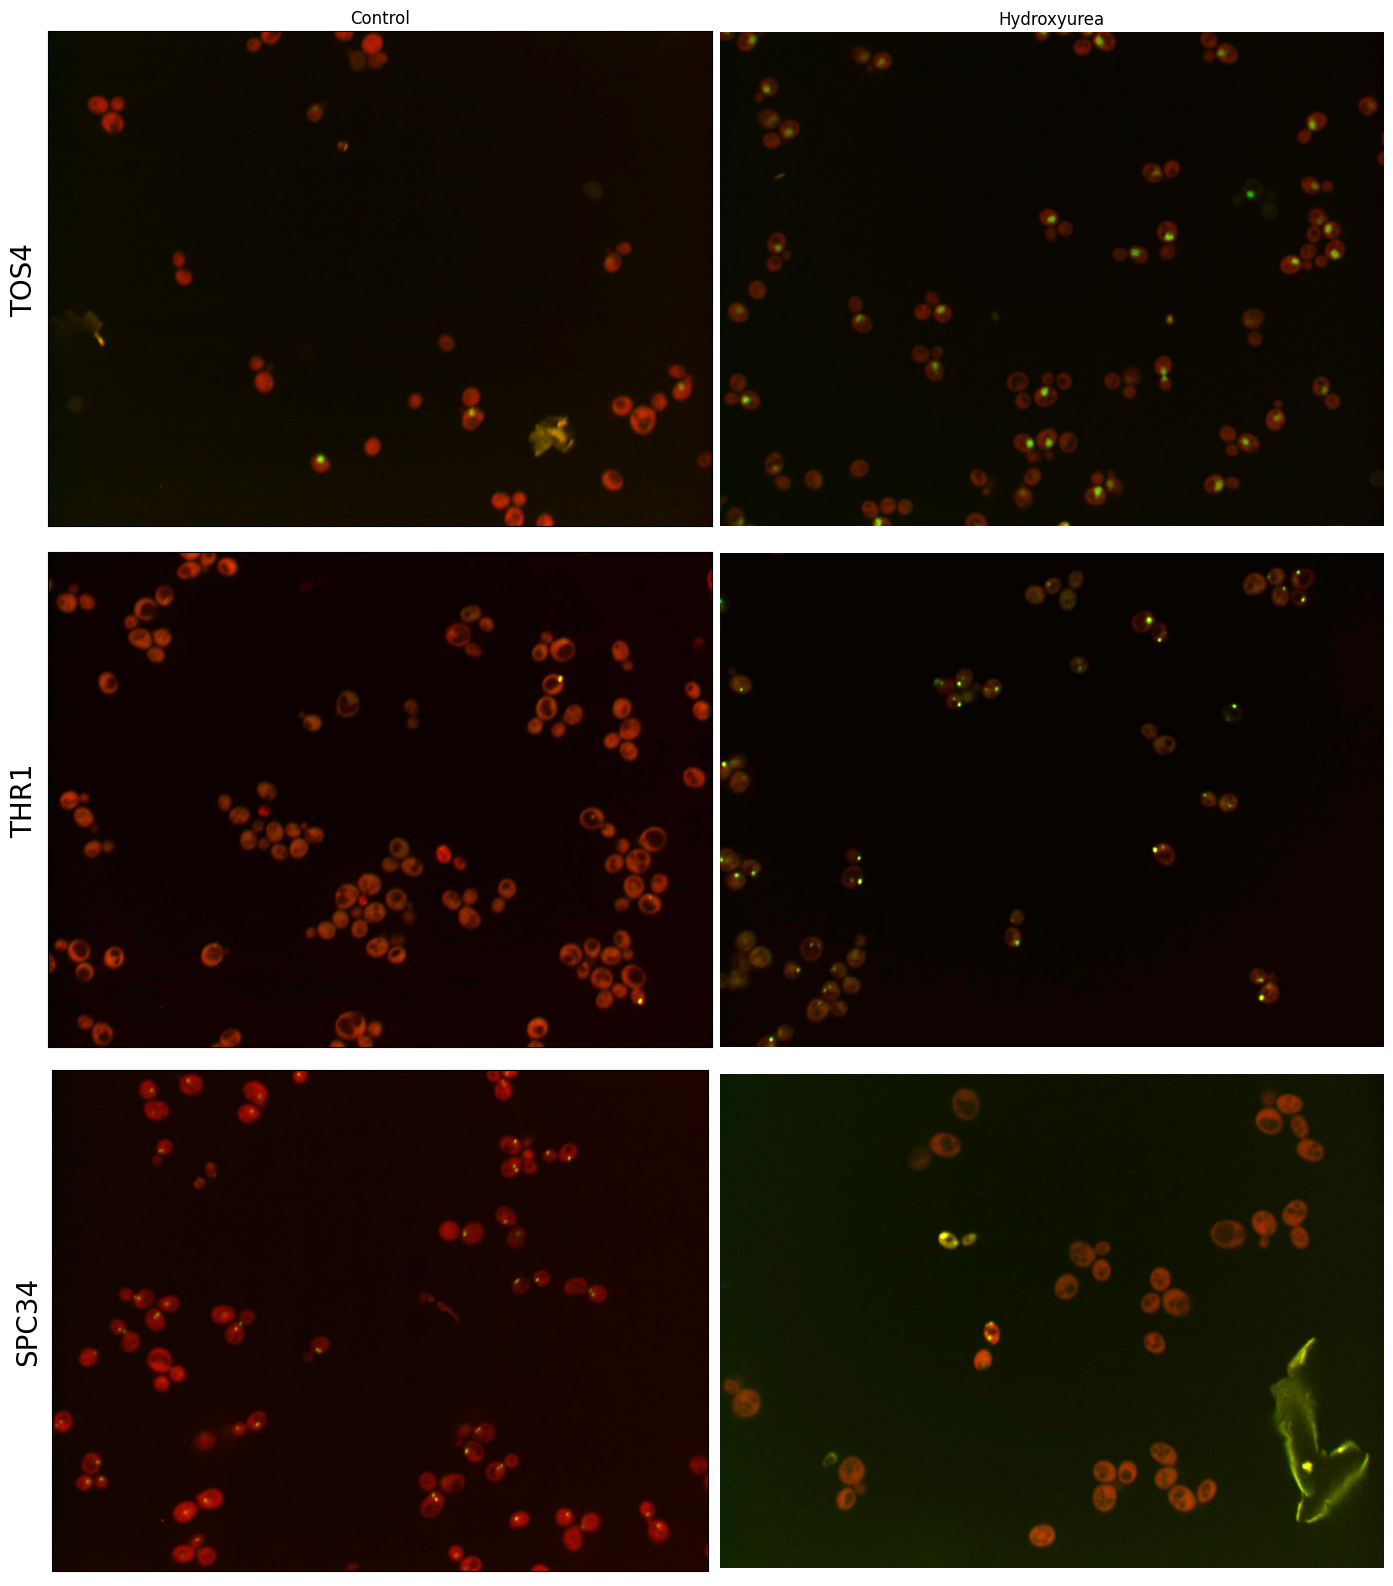

In [22]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.exposure import rescale_intensity

# Open WT control images
tos4_wt = np.array(Image.open('./data/cyclops/HU02_changes/tos4_ctrl.png'))
thr1_wt = np.array(Image.open('./data/cyclops/HU02_changes/thr1_ctrl.png'))
spc34_wt = np.array(Image.open('./data/cyclops/HU02_changes/spc34_ctrl.png'))

# Open hydroxyurea images
tos4_hu = np.array(Image.open('./data/cyclops/HU02_changes/tos4_hu02.png'))
thr1_hu = np.array(Image.open('./data/cyclops/HU02_changes/thr1_hu02.png'))
spc34_hu = np.array(Image.open('./data/cyclops/HU02_changes/spc34_hu02.png'))

# Plot
fig = plt.figure(figsize=(14, 16))
ax1 = fig.add_subplot(3, 2, 1)
ax1.imshow(tos4_wt)
ax1.set_title("Control")
ax1.set_ylabel('TOS4', fontsize=20)
ax1.set_xticks([])
ax1.axes.xaxis.set_ticklabels([])
ax1.set_yticks([])
ax1.axes.yaxis.set_ticklabels([])

ax2 = fig.add_subplot(3, 2, 2)
ax2.imshow(tos4_hu)
ax2.set_title("Hydroxyurea")
ax2.axis("off")

ax3 = fig.add_subplot(3, 2, 3)
ax3.imshow(thr1_wt)
ax3.set_ylabel('THR1', fontsize=20)
ax3.set_xticks([])
ax3.axes.xaxis.set_ticklabels([])
ax3.set_yticks([])
ax3.axes.yaxis.set_ticklabels([])

ax4 = fig.add_subplot(3, 2, 4)
ax4.imshow(thr1_hu)
ax4.axis("off")

ax5 = fig.add_subplot(3, 2, 5)
ax5.imshow(spc34_wt)
ax5.set_ylabel('SPC34', fontsize=20)
ax5.set_xticks([])
ax5.axes.xaxis.set_ticklabels([])
ax5.set_yticks([])
ax5.axes.yaxis.set_ticklabels([])

ax6 = fig.add_subplot(3, 2, 6)
ax6.imshow(spc34_hu)
ax6.axis("off")
plt.tight_layout()
plt.show()